<a href="https://colab.research.google.com/github/malvibid/COMP3029-Computer-Vision/blob/main/COMP3029_Computer_Vision_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMP3029 COMPUTER VISION COURSEWORK** 

*Spring 2022/2023*, School of Computer Science, University of Nottingham Malaysia

```
GROUP 4: 
  20306551 - Mustafa Mehmood
  20311657 - Omar Ismail
  20311860 - Gabriel Hoh Chao Jei
  20187945 - Malvi Bid
```





# ⚡Challenges

```
Key: ✅ Challenge solved 🟥 Pending solution
```

*   ✅ 6 images in Batch-3 were not being segmented correctly. I double-checked the bounding box coordinates and drew them on the image, they were positioned correctly. After further inspection I realised the issue was with the PIL image library we were using. Therefore, I switched to using OpenCV, this resolved the issue. 

# Import Dependencies

In [1]:
import os
import cv2
import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from google.colab import drive
from google.colab.patches import cv2_imshow

# Mount google drive

In [2]:
# Mount drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Dataset folder structure

In [ ]:
!ls -F '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/'

Batch-1/  Batch-2/  Batch-3/


In [ ]:
print("Batch-1/ ")
!ls -F -X '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-1'
print("\nBatch-2/ ")
!ls -F -X '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2'
print("\nBatch-3/ ")
!ls -F -X '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3'

Batch-1/ 
seedsegment@  seedsplit@

Batch-2/ 
NormalRoomLighting@  seedsegment/  NormalRoomLight_annotation.csv

Batch-3/ 
LightBox@  seedsegment/  LightBox_annotation.csv


## Dataset structure tree

### Original folders tree


```
.
└── Datasets/
    ├── Batch-1/
    │   └── seedsegment/
    │       ├── test/
    │       │   ├── BadSeed/
    │       │   └── GoodSeed/
    │       │
    │       └── train/
    │           ├── BadSeed/
    │           └── GoodSeed/
    │
    ├── Batch-2/
    │   ├── NormalRoomLight_annotation.csv
    │   └── NormalRoomLighting/
    │       ├── Set1/
    │       ├── ...
    │       └── Set15/
    │
    └── Batch-3/
        ├── LightBox_annotation.csv
        └── LightBox/
            ├── Set1/
            ├── ...
            └── Set20/
```

### Folders tree after extracting Batch-2 and Batch-3 images



```
└── Datasets/
    ├── Batch-1/
    │   └── seedsegment/
    │       ├── test/
    │       │   ├── BadSeed/
    │       │   └── GoodSeed/
    │       └── train/
    │           ├── BadSeed/
    │           └── GoodSeed/
    ├── Batch-2/
    │   ├── seedcropped/
    │   │   └── test/
    │   │       ├── BadSeed/
    │   │       └── GoodSeed/
    │   └── seedsegment/
    │       └── test/
    │           ├── BadSeed/
    │           └── GoodSeed/
    └── Batch-3/
        ├── seedcropped/
        │   └── test/
        │       ├── BadSeed/
        │       └── GoodSeed/
        └── seedsegment/
            └── test/
                ├── BadSeed/
                └── GoodSeed/
  ```

# Extracting Batch-2 and Batch-3 individual seed images

The individual seed images have been extracted in folders as per the [folder structure](#scrollTo=N7skd4hymIFJ&line=46&uniqifier=1) defined in the dataset folder structure section above.

For sake of comparison, we extracted two versions of individual seed images for both Batch-2 and Batch-3. In the first version, the images are only cropped as per the given bounding box coordinates. The resulting cropped images have been extracted in a folder named `seedcropped`. Whereas in the second version, similar to the images in Batch-1, the images have been cropped and resized to 256px by 256px. These images have been extracted in a folder named `seedsegment`. 

In [ ]:
def extract_seed_image(annotations_csv, resize=True):
  print("Extracting images...")
  # Read the CSV file
  seed_df = pd.read_csv(annotations_csv)

  for index, row in seed_df.iterrows():
    # Get all image variables
    img_path = row["file_name"].rsplit('.')[0] + '.JPG'
    x_min, y_min, x_max, y_max = row["x_min"], row["y_min"], row["x_max"], row["y_max"]
    class_label = 'GoodSeed' if row["bbox_label"] == 'GOOD' else 'BadSeed' if row["bbox_label"] == 'BAD' else 'Labelling error' # Ensuring each sample in the csv is labelled correctly.
    
    # Read the image file
    image = cv2.imread(img_path)

    # Crop the image using the given bounds
    cropped_image = image[y_min:y_max, x_min:x_max].copy()

    if resize:
      # Resize the cropped image to 256x256
      resized_image = cv2.resize(cropped_image, (256, 256), interpolation=cv2.INTER_AREA)
      folder_name = 'seedsegment'
    else:
      folder_name = 'seedcropped'

    # Specify path to save the extracted image. Batch-<num>/<folder_name>/test/<class-cabel>
    data_dir = os.path.join(os.path.dirname(annotations_csv) , f'{folder_name}/test/{class_label}')

    # Create new folders if they don't exist on the path
    if not os.path.exists(data_dir):
      os.makedirs(data_dir)

    # Formatting the image name to <label>test<index>.jpg E.g., goodtest0.jpg, badtest12.jpg
    image_name = f'{row["bbox_label"].lower()}test{index}.jpg' 
    
    if resize:
      # Save the extracted image to specified folder E.g. Batch-2/seedsegment/test/GoodSeed/goodtest0.jpg
      cv2.imwrite(f'{data_dir}/{image_name}', resized_image)
    else:
      # Save the extracted image to specified folder E.g. Batch-2/seedcropped/test/GoodSeed/goodtest0.jpg
      cv2.imwrite(f'{data_dir}/{image_name}', cropped_image)

  print(f'Extracted images saved at: {os.path.dirname(data_dir)}/')
  print("✅ Individual seed image extraction completed.")


In [5]:
# Setting paths to the dataset and annotation files
dataset_root_dir = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/'

batch2_annotations_dir = os.path.join(dataset_root_dir, 'Batch-2/NormalRoomLight_annotation.csv')
batch3_annotations_dir = os.path.join(dataset_root_dir, 'Batch-3/LightBox_annotation.csv')

In [ ]:
# Extract Batch-2 images - only cropped
extract_seed_image(batch2_annotations_dir, resize=False)

Extracting images...
Extracted images saved at: /content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedcropped/test/
✅ Individual seed image extraction completed.


In [ ]:
# Extract Batch-2 images - cropped and resized to 256x256
extract_seed_image(batch2_annotations_dir, resize=True)

Extracting images...
Extracted images saved at: /content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedsegment/test/
✅ Individual seed image extraction completed.


In [ ]:
# Extract Batch-3 images - only cropped
extract_seed_image(batch3_annotations_dir, resize=False)

Extracting images...
Extracted images saved at: /content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedcropped/test/
✅ Individual seed image extraction completed.


In [ ]:
# Extract Batch-3 images  - cropped and resized to 256x256
extract_seed_image(batch3_annotations_dir, resize=True)

Extracting images...
Extracted images saved at: /content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedsegment/test/
✅ Individual seed image extraction completed.


## Comparing `seedcropped` and `seedsegment` images for Batch-2 and Batch-3

Here is a comparison of the images just cropped vs images cropped and resized. 

Batch 2, sample: 'badtest11.jpg'


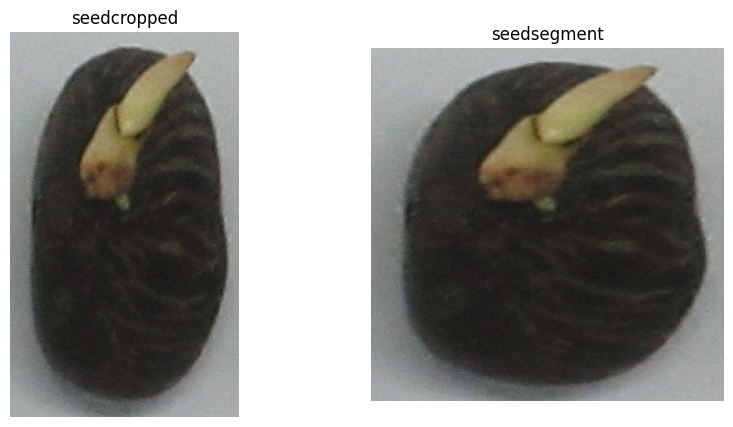



Batch 3, sample: 'badtest13.jpg'


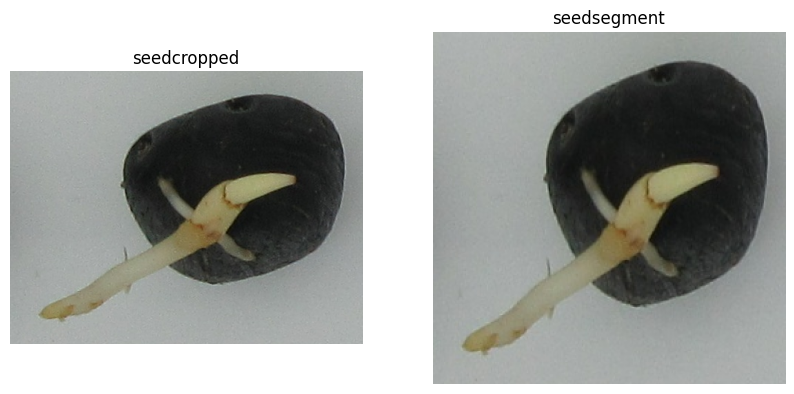

In [ ]:
def display_side_by_side(imgpath1, imgpath2):
  # Load images
  img1 = cv2.imread(imgpath1)
  img2 = cv2.imread(imgpath2)

  # Convert images from BGR to RGB (OpenCV reads images in BGR format)
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

  # Create a figure and subplots
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  # Plot images side by side
  axs[0].imshow(img1)
  axs[0].axis('off')
  axs[0].set_title('seedcropped')

  axs[1].imshow(img2)
  axs[1].axis('off')
  axs[1].set_title('seedsegment')

  # Display the plot
  plt.show()


print("Batch 2, sample: 'badtest11.jpg'")
b2imgpath1 = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedcropped/test/BadSeed/badtest11.jpg'
b2imgpath2 = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedsegment/test/BadSeed/badtest11.jpg'

display_side_by_side(b2imgpath1, b2imgpath2)

print("\n\nBatch 3, sample: 'badtest13.jpg'")
b3imgpath1 = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedcropped/test/BadSeed/badtest13.jpg'
b3imgpath2 = '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedsegment/test/BadSeed/badtest13.jpg'

display_side_by_side(b3imgpath1, b3imgpath2)


# Custom Seed Dataset and Dataloader


In [3]:
# Custom dataset class inheriting from the PyTorch Dataset class
class SeedDataset(Dataset):
    def __init__(self, dataset_dir=None, train=True, transform=None):
        self.dataset_dir = dataset_dir
        self.train = train
        self.transform = transform
        self.categories = ['BadSeed', 'GoodSeed']
                
        self.data = []
        
        data_dir = os.path.join(self.dataset_dir, 'train' if self.train else 'test')
        for category_idx, category in enumerate(self.categories):
          category_dir = os.path.join(data_dir, category)
          for img_name in os.listdir(category_dir):
              if img_name.endswith('.png') or img_name.endswith('.jpg'):
                  self.data.append((img_name, os.path.join(category_dir, img_name), category_idx))
        
        #print(self.data)
                    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
      
      img_name, img_path, label = self.data[idx]

      # Read the image file in BGR format
      image_bgr = cv2.imread(img_path)
      
      # Convert the image from BGR to RGB format
      seed_img = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

      
      if self.transform:
          seed_img = self.transform(seed_img)

      return img_name, seed_img, label

**Note:** The base dataset directory was defined [above](#scrollTo=PKtkhahQMNDb&line=1&uniqifier=1) when extracting B2 and B3 individual seed images. 
You may change the base path there or replace `os.path.join(dataset_root_dir, 'Batch-<num>/seedsegment')` below to an absolute path to the cropped (seedsegment) images in your drive for each batch.

In [6]:
# Defining paths to dataset directories
batch1_dataset_dir = os.path.join(dataset_root_dir, 'Batch-1/seedsegment')
batch2_dataset_dir = os.path.join(dataset_root_dir, 'Batch-2/seedsegment')
batch3_dataset_dir = os.path.join(dataset_root_dir, 'Batch-3/seedsegment')

In [7]:
# Define the image transformations
image_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [8]:
# Define batch size
BATCH_SIZE = 32

In [9]:
# Instantiate the custom SeedDataset and dataloader

# Get Training dataset from Batch-1
train_dataset = SeedDataset(dataset_dir=batch1_dataset_dir, train=True, transform=image_transforms)

# Split Training dataset into Training and Validation sets with a roughly 80/20 split
train_b1_dataset, validate_b1_dataset = random_split(train_dataset, [int(0.8 * len(train_dataset)), len(train_dataset) - int(0.8 * len(train_dataset))])

# Load Training and Validation datesets.
train_b1_dataloader = DataLoader(dataset=train_b1_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validate_b1_dataloader = DataLoader(dataset=validate_b1_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Get and load Testing dataset from Batch-1,2,3
test_b1_dataset = SeedDataset(dataset_dir=batch1_dataset_dir, train=False, transform=image_transforms)
test_b1_dataloader = DataLoader(dataset=test_b1_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_b2_dataset = SeedDataset(dataset_dir=batch2_dataset_dir, train=False, transform=image_transforms)
test_b2_dataloader = DataLoader(dataset=test_b2_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_b3_dataset = SeedDataset(dataset_dir=batch3_dataset_dir, train=False, transform=image_transforms)
test_b3_dataloader = DataLoader(dataset=test_b3_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


## Testing dataset and dataloader

In [15]:
# Checking the dataset length and a sample of data
print(f"B1 Train Dataset length: {len(train_b1_dataset)}")
print(f"B1 Train Data sample: {train_dataset.data[train_b1_dataset.indices[0]]}\n") # Access the first training sample from the original train_dataset using the index of first training sub-sample

print(f"B1 Validation Dataset length: {len(validate_b1_dataset)}")
print(f"B1 Validation Data sample: {train_dataset.data[validate_b1_dataset.indices[0]]}\n") # Access the first validation sample from the original train_dataset using the index of first validation sub-sample

print(f"B1 Test Dataset length: {len(test_b1_dataset.data)}")
print(f"B1 Test Data sample: {test_b1_dataset.data[0]}\n")

print(f"B2 Test Dataset length: {len(test_b2_dataset.data)}")
print(f"B2 Test Data sample: {test_b2_dataset.data[0]}\n")

print(f"B3 Test Dataset length: {len(test_b3_dataset.data)}")
print(f"B3 Test Data sample: {test_b3_dataset.data[0]}\n")

B1 Train Dataset length: 1402
B1 Train Data sample: ('goodtrain800.png', '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-1/seedsegment/train/GoodSeed/goodtrain800.png', 1)

B1 Validation Dataset length: 350
B1 Validation Data sample: ('goodtrain88.png', '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-1/seedsegment/train/GoodSeed/goodtrain88.png', 1)

B1 Test Dataset length: 401
B1 Test Data sample: ('badtest2.png', '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-1/seedsegment/test/BadSeed/badtest2.png', 0)

B2 Test Dataset length: 900
B2 Test Data sample: ('badtest10.jpg', '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-2/seedsegment/test/BadSeed/badtest10.jpg', 0)

B3 Test Dataset length: 1198
B3 Test Data sample: ('badtest10.jpg', '/content/drive/My Drive/UNM/COMP3029-Computer-Vision-Labs/Coursework/Datasets/Batch-3/seedsegment/test/BadSe

In [16]:
# Get a batch of data from the data loader
b1_train_img_names, b1_train_images, b1_train_labels = next(iter(train_b1_dataloader))
b1_validate_img_names, b1_validate_images, b1_validate_labels = next(iter(validate_b1_dataloader))
b1_test_img_names, b1_test_images, b1_test_labels = next(iter(test_b1_dataloader))
b2_test_img_names, b2_test_images, b2_test_labels = next(iter(test_b2_dataloader))
b3_test_img_names, b3_test_images, b3_test_labels = next(iter(test_b3_dataloader))

### Visualise batches

B1 Train image batch shape: torch.Size([32, 3, 256, 256])
B1 Train labels batch shape: torch.Size([32])
B1 Train labels: tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 0])


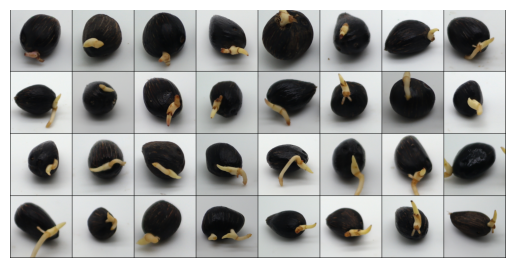

In [17]:
# Train batch
print(f"B1 Train image batch shape: {b1_train_images.size()}")
print(f"B1 Train labels batch shape: {b1_train_labels.size()}")
print(f"B1 Train labels: {b1_train_labels}")

# Create a grid of images from the batch to see the individual seed samples
grid = vutils.make_grid(b1_train_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

B1 Validate image batch shape: torch.Size([32, 3, 256, 256])
B1 Validate labels batch shape: torch.Size([32])
B1 Validate labels: tensor([0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 1, 1, 1])


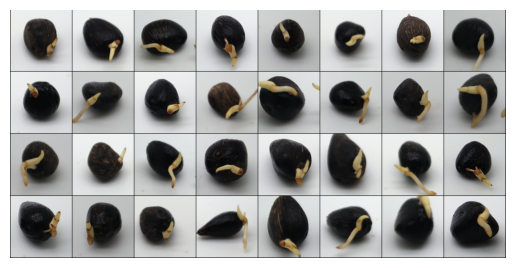

In [18]:
# Validation batch
print(f"B1 Validate image batch shape: {b1_validate_images.size()}")
print(f"B1 Validate labels batch shape: {b1_validate_labels.size()}")
print(f"B1 Validate labels: {b1_validate_labels}")

# Create a grid of images from the batch to see the individual seed samples
grid = vutils.make_grid(b1_validate_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

B1 Test image batch shape: torch.Size([32, 3, 256, 256])
B1 Test labels batch shape: torch.Size([32])
B1 Test Labels: tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0])


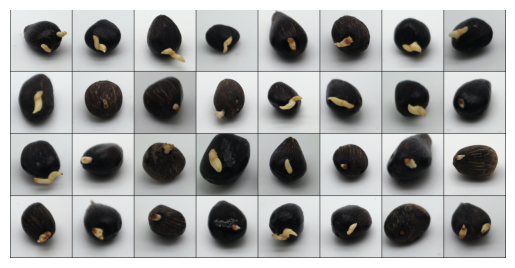

In [19]:
# Test B1
print(f"B1 Test image batch shape: {b1_test_images.size()}")
print(f"B1 Test labels batch shape: {b1_test_labels.size()}")
print(f"B1 Test Labels: {b1_test_labels}")

# Create a grid of images from the batch to see the individual seed samples
grid = vutils.make_grid(b1_test_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

B2 Test image batch shape: torch.Size([32, 3, 256, 256])
B2 Test labels batch shape: torch.Size([32])
B2 Test Labels: tensor([0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 0])


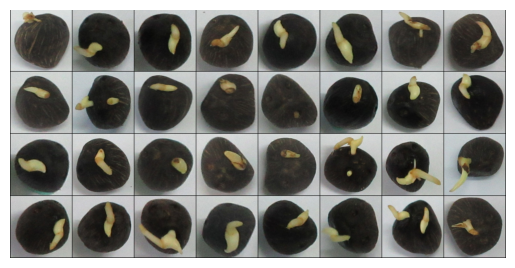

In [20]:
# Test B2
print(f"B2 Test image batch shape: {b2_test_images.size()}")
print(f"B2 Test labels batch shape: {b2_test_labels.size()}")
print(f"B2 Test Labels: {b2_test_labels}")

# Create a grid of images from the batch to see the individual seed samples
grid = vutils.make_grid(b2_test_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

B3 Test image batch shape: torch.Size([32, 3, 256, 256])
B3 Test labels batch shape: torch.Size([32])
B3 Test Labels: tensor([1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 0])


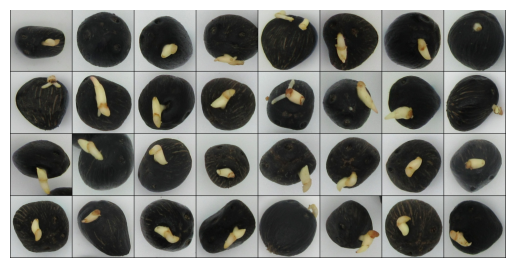

In [21]:
# Test B3
print(f"B3 Test image batch shape: {b3_test_images.size()}")
print(f"B3 Test labels batch shape: {b3_test_labels.size()}")
print(f"B3 Test Labels: {b3_test_labels}")
# Create a grid of images from the batch to see the individual seed sample
grid = vutils.make_grid(b3_test_images, nrow=8, padding=2, normalize=True)

# Display the grid
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()